In [0]:
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
from collections import defaultdict

In [0]:
n_nodes = 196591 # количество узлов графа 
n_edges = 950327 # количество ребер графа
n_check_ins = 6442890 # чекины

In [0]:
# Обработка данных

In [0]:
with open('Gowalla_edges.txt', 'r') as f:
    all_strings = f.readlines()
edges_list = [] # список всех связей
nodes = set() # множество всех пользователей
s_array = [] # массив similarity (без self-similarity)
 
for line in all_strings:
    user_1, user_2 = line.split()
    # заполняем список всех связей в формате "кто дружит, с кем дружит"
    edges_list.append((int(user_1), int(user_2)))
    nodes.add((int(user_1)))
    # каждую дружбу отмечаем 1 в similarity
    s_array.append(1)
# дополним список связей связями "сам к себе"
for node in nodes:
    edges_list.append((node, node))

s_array = np.array(s_array, dtype=np.int8)
all_strings = None

In [0]:
# Функции кластеризации

In [0]:
def affinity_propagation(s, edges, max_iter, self_similarity):
    # формируем массив self-similarity
    self_s_array = np.repeat(self_similarity, n_nodes)
    # формируем полный массив similarity (значения self-similarity будут в конце массива)
    similarity = np.append(s, self_s_array)
    # инициализируем нулями массивы availability и responsibility
    responsibility = np.repeat(0, similarity.shape[0])
    availability = np.repeat(0, similarity.shape[0])
    
    for iteration in range(max_iter):
        # обновляем responsibility
        responsibility = refresh_responsibility(similarity, availability, edges)
        # обновляем availability
        availability = refresh_availability(availability, responsibility, edges)
        print(iteration)
    # для каждого пользователя получаем экземпляр класстера
    exemplars = get_exemplars(availability, responsibility, edges_list)
    # производим транзитивную свертку
    result = transitiv_convolution(exemplars)
    
    return result

In [0]:
def refresh_responsibility(S, A, edges):
    max_1 = np.repeat(-np.inf, n_nodes)
    max_2 = np.repeat(-np.inf, n_nodes)
    max_1_user_2 = np.repeat(np.inf, n_nodes)
    # поэлементное сложение массивов similarity и availability
    S_A = S + A
    # итерируемся по списку связей
    for idx, (user_1, user_2) in enumerate(edges):
        # для каждого пользователя найдем 2 наибольших значения суммы s(i,j) + a(i,j)
        if max_1[user_1] < S_A[idx]:
            max_2[user_1] = max_1[user_1]
            max_1[user_1] = S_A[idx]
            # запоминаем пользователя 2 с которым у пользователя 1 максимальное s(i,j) + a(i,j)
            max_1_user_2[user_1] = user_2
        elif max_2[user_1] < S_A[idx]:
            max_2[user_1] = S_A[idx]
    # обновляем  массив responsibility
    R = S.copy()

    for idx, (user_1, user_2) in enumerate(edges):
        if max_1_user_2[user_1] == user_2:
            R[idx] -= max_2[user_1]
        else:
            R[idx] -= max_1[user_1]
    
    return R        

In [0]:
def refresh_availability(A, R, edges):
    # сохраняем только положительные r, self-r не изменяем
    R_copy = R.copy()
    i = 0
    while i < n_edges * 2:
        if R_copy[i] < 0:
            R_copy[i] = 0
        i += 1
    # для каждого пользователя складываем положительные r от других пользователей
    positive_r = np.repeat(0, n_nodes)
    
    for idx, (user_1, user_2) in enumerate(edges):
        positive_r[user_2] += R_copy[idx]
    # обновляем availability
    for idx, (user_1, user_2) in enumerate(edges):
        A[idx] = positive_r[user_2] - R_copy[idx]
    
    i = 0
    while i < n_edges * 2:
        A[i] = np.min([0, A[i]])
        i += 1
    
    return A
    
        

In [0]:
def get_exemplars(A, R, edges):
    temp_array = np.repeat(-np.inf, n_nodes)
    exemplars_dict = dict()
    # поэлементное сложение массивов availability и responsibility
    a_plus_r = A + R
    # для каждого пользователя 1 определяем пользователя 2 c максимальным a(i,j) + r(i,j)
    for idx, (user_1, user_2) in enumerate(edges):
        if a_plus_r[idx] > temp_array[user_1]:
            temp_array[user_1] = a_plus_r[idx]
            exemplars_dict[user_1] = user_2
    
    return exemplars_dict
    

In [0]:
def transitiv_convolution(exemplars_dict):
    for i in range(5):
        for key in exemplars_dict.keys():
            value = exemplars_dict[key]
            if exemplars_dict[value] != value:
                value_2 = exemplars_dict[value]
                exemplars_dict[key] = value_2
        
    return exemplars_dict

In [0]:
# Кластеризация графа
my_exemplars = affinity_propagation(s_array, edges_list, 10, -1.5)

0
1
2
3
4
5
6
7
8
9


In [0]:
some_set = set()
for i in my_exemplars.values():
    some_set.add(i)

In [0]:
len(some_set)

17955

In [0]:
# Визуализация размеров кластера
cluster_size = dict()
for exemplar in my_exemplars.values():
    if exemplar not in cluster_size:
        cluster_size[exemplar] = 1
    else:
        cluster_size[exemplar] += 1

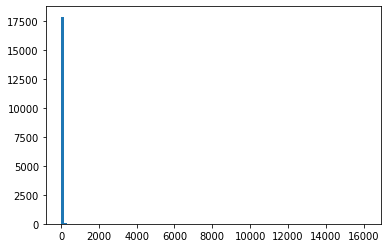

In [0]:
%matplotlib inline
plt.hist(cluster_size.values(), bins=100)
plt.show()

In [0]:
# Большая часть значений находится ближе к 0

In [0]:
max(cluster_size.values()) # Размер самого большого кластера

16100

In [0]:
min(cluster_size.values()) # Размер самого маленького кластера

1

In [0]:
# Визуализируем наиболее распространенные размеры кластеров

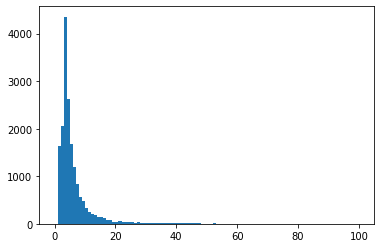

In [0]:
plt.hist(cluster_size.values(), bins=100, range=(0, 100))
plt.show()

In [0]:
# Обработка данных по чекинам

In [0]:
checkins = []

with open('Gowalla_totalCheckins.txt', 'r') as f:
    for line in f.readlines():
        line = line[:-1]
        line = line.split('\t')
        user, loc = int(line[0]), int(line[-1])
        checkins.append((user, loc))

In [0]:
checkins_by_user = defaultdict(list)

for (user, loc) in checkins:
    checkins_by_user[user].append(loc)

In [0]:
np.random.seed(0)

users = list(set(checkins_by_user.keys()))
users = np.array(users)
np.random.shuffle(users)

train_test_split = 0.1
split_ind = int(train_test_split*len(users))

users_train, users_test = users[split_ind:], users[:split_ind]
print("Users in train set: %d, users in test set: %d" % (len(users_train), len(users_test)))

Users in train set: 96383, users in test set: 10709


In [0]:
locations = np.array(list(set([x[1] for x in checkins])))
n_locations = len(locations)

loc_to_ind = {x:i for i,x in enumerate(locations)}

In [0]:
# baseline классификатор

In [0]:
k = 10

# train
checkin_count = np.zeros_like(locations)
for user in users_train:
    for loc in checkins_by_user[user]:
        checkin_count[loc_to_ind[loc]] += 1

topk_ind = np.argpartition(checkin_count, -k)[-k:]
topk_ind = topk_ind[np.argsort(checkin_count[topk_ind])]

topk_recommended_locations = locations[topk_ind[::-1]]
print("Top-10 locations: ", topk_recommended_locations)
print("Check-ins count: ", checkin_count[topk_ind[::-1]])

Top-10 locations:  [55033 19542  9410 10259 58725 14470 10190  9246 23256  9241]
Check-ins count:  [5154 5003 4234 3775 3146 3093 3076 3045 3025 2992]


In [0]:
# test
precision_at_k = 0

for user in users_test:
    relevant = 0
    for loc in topk_recommended_locations:
        if loc in checkins_by_user[user]:
            relevant += 1
    precision_at_k += relevant/k

precision_at_k /= len(users_test)
print("Mean precision@10 = ", precision_at_k)

Mean precision@10 =  0.01757400317489932


In [0]:
locations_by_clusters = dict()
for (user, location) in checkins:
    if user in users_train:
        exemplar = my_exemplars[user]
        
        if exemplar not in locations_by_clusters.keys():
            locations_by_clusters[exemplar] = dict()
            
        else:
            if location not in locations_by_clusters[exemplar].keys():
                locations_by_clusters[exemplar][location] = 1
            else:
                locations_by_clusters[exemplar][location] += 1

In [0]:
# Отсортируем локации по убыванию количества чекинов и определим топ-10 локаций для каждого кластера.
top_k_locations_for_clusters = dict()
for exemplar in locations_by_clusters:
    locations_by_clusters[exemplar] = [[k, v] for k, v in sorted(locations_by_clusters[exemplar].items(), key=lambda item: item[1], reverse=True)]
for exemplar in locations_by_clusters:
    top_k_locations_for_clusters[exemplar] = [location[0] for location in locations_by_clusters[exemplar][:k]]

In [0]:
top_k_locations_for_clusters[0]

[9410, 19542, 9246, 26919, 420315, 9241, 10259, 33793, 21714, 9066]

In [0]:
# Рассчёт precision@10 с применением кластеризации
hits = 0
for (user, location) in checkins:
    if user in  users_test:
        exemplar = my_exemplars[user]
        if exemplar in top_k_locations_for_clusters and location in top_k_locations_for_clusters[exemplar]:
            hits += 1
precision_10 = hits / k / len(users_test)

In [0]:
precision_10

0.12764964048930805

Результаты:
self-similarity: -1.5
итераций: 10
количество кластеров: 17955
precision@10 для baseline: 0.13
precision@10 для кластеров: 0.44